# 1. Simulation Environment Setup and Patient Model Definition
First, we define the environment and patient model necessary for the simulation. The patient's daily mood is expressed as a continuous value ranging from 0 to 10, while fatigue is a variable that increases with cumulative activity and decreases with rest. Treatment activities are assumed to be performed through BAT tasks, where engaging in activities can result in positive effects on mood (when fatigue is low) or negative effects (when fatigue is high). Additionally, performing activities increases fatigue, while resting allows for some recovery of fatigue. A random noise of ±0.5 is added to the mood each day to simulate a bit of uncertainty. The code below initializes these simulation parameters.

In [2]:
import numpy as np

# 시드 고정 (재현 가능성)
np.random.seed(42)

N = 100   # patinet size
T = 56    # simulation times

MAX_MOOD = 10

# mean : 5.0, std : 1.0, normal distribution. clipping in [0, 10]
INITIAL_MOOD = np.random.normal(loc=5.0, scale=1.0, size=N)
INITIAL_MOOD = np.clip(INITIAL_MOOD, 0, MAX_MOOD)

# initial fatigue start from 0(full rest)
INITIAL_FATIGUE = np.zeros(N)

mood_noise = np.random.normal(loc=0.0, scale=0.5, size=(N, T))
# random table to decide adverse event
adverse_rand = np.random.rand(N, T)


# 2. Simulation Execution by Strategy (Safe vs. Greedy vs. Static)
Now, we simulate the patient group according to three treatment strategies:

- Safe Strategy: A conservative approach that adheres to safety constraints in accordance with the proposed SAFE_DTx framework. Specifically, if fatigue is high, the intervention for that day is skipped, and intervention is only recommended when the mood falls below a certain level. (In this case, behavior recommendations are made only when mood < 5 and fatigue < 5)

- Greedy Strategy: An aggressive strategy that attempts intervention daily without considering safety or fatigue. It recommends interventions at the maximum frequency possible, which may lead to significant short-term effects but also increases the risk of side effects due to cumulative fatigue.

- Static Strategy: A strategy that intervenes at fixed intervals regardless of the patient's condition. (In this case, activities are recommended every other day, alternating between intervention and rest)

Each day, the recommendation is determined, and the patient probabilistically decides whether to adhere to the recommendation and actually perform the activity. Adherence probability varies based on the patient's current fatigue level: higher fatigue results in lower participation rates, while lower fatigue results in higher participation rates. The effects of the behavior are as follows:

- When the activity is performed: The patient's mood improves (a basic increase of +2), but fatigue increases (+2 cumulative). However, if the patient is already in a high fatigue state (fatigue ≥ 5), engaging in activities incurs a 20% chance of a negative event, causing a sharp decline in mood (a decrease of -3). Otherwise, a slight positive effect is observed (+1).

- When resting from activities: The patient's mood slightly decreases (-0.5, simulating a loss of motivation), while fatigue is recovered (-1.0 decrease).

According to these rules, the state of mood and fatigue is updated at the end of each day. To keep all values within realistic ranges, mood is clipped to remain within the range of [0, 10], and fatigue is prevented from dropping below 0, with an upper limit of 10 (considered as extreme fatigue). The following code simulates the 56-day progression for 100 patients under each of the three strategies. Ultimately, we collect daily data on mood and fatigue changes, recommendations, and actual performance for each strategy.

In [ ]:
results = {}

for strategy in ["safe", "greedy", "static"]:
    moods = np.zeros((N, T+1))
    fatigues = np.zeros((N, T+1))

    moods[:, 0] = INITIAL_MOOD
    fatigues[:, 0] = INITIAL_FATIGUE
    recommended = np.zeros((N, T), dtype=bool) # wheater recoomended
    taken = np.zeros((N, T), dtype=bool) # wheather adhere
    
    for t in range(T):
        if strategy == "safe":
            # Safe strategy : recommend only if fatigue is low
            do_action = (fatigues[:, t] < 5) & (moods[:, t] < 5)
        elif strategy == "greedy":
            # Greedy stragegy : recommend if moood is not maximum
            do_action = np.ones(N, dtype=bool)
            do_action = do_action & (moods[:, t] < MAX_MOOD) 
        elif strategy == "static":
            # Static strategy : recommend if t is even
            do_action = np.zeros(N, dtype=bool)
            if t % 2 == 0:
                do_action[:] = True
        else:
            do_action = np.zeros(N, dtype=bool)
        
        recommended[:, t] = do_action
        
        # adherer probability
        # - fatigue > 7: 0% 
        # - 5 < fatigue <= 7: 50% 
        # - fatigue <= 5: 90% 
        adh_prob = np.where(fatigues[:, t] > 7, 0.0,
                            np.where(fatigues[:, t] > 5, 0.5, 0.9))
        rand_adh = np.random.rand(N)
        actual_action = (rand_adh < adh_prob) & do_action
        
        taken[:, t] = actual_action
        
        mood_change = np.zeros(N)
        fatigue_change = np.zeros(N)
        
        # 1) treat engaged patient
        idx = np.where(actual_action)[0]
        if idx.size > 0:
            # high fatigue group vs low fiatigue group
            high_fatigue_idx = idx[fatigues[idx, t] >= 5]  # high fatigue
            normal_fatigue_idx = idx[fatigues[idx, t] < 5] # low fiatigue
            
            # low fatigue group : increase mood  +2, increate fatigue +2
            if normal_fatigue_idx.size > 0:
                mood_change[normal_fatigue_idx] = 2.0
            
            # high fatigue group : adverse event possible
            if high_fatigue_idx.size > 0:
                # adverse event with 20% 
                adverse_trigger = adverse_rand[high_fatigue_idx, t] < 0.2
                # if happen : decrease mood 3, else : increase mood 1
                mood_change[high_fatigue_idx] = np.where(adverse_trigger, -3.0, 1.0)
                
            fatigue_change[high_fatigue_idx] = 2.0  # increate fatigue +2
        
        # 2) treat not engaged patient (not recommended or recommended nub not adhrere)
        no_action_idx = np.where(~actual_action)[0]
        if no_action_idx.size > 0:
            # if not taken : mood -0.5, fatigue -1 
            mood_change[no_action_idx] = -0.5
            fatigue_change[no_action_idx] = -1.0
        
        # 3) add ranom noise to every patient
        mood_change += mood_noise[:, t]
        
        # update mood/fatigue
        new_mood = moods[:, t] + mood_change
        new_fatigue = fatigues[:, t] + fatigue_change
        # clipping (mood: 0~10, fatigue: 0~10)
        new_mood = np.clip(new_mood, 0, 10)
        new_fatigue = np.clip(new_fatigue, 0, 10)
        
        # set next dat state
        moods[:, t+1] = new_mood
        fatigues[:, t+1] = new_fatigue
    
    # store simulation result
    results[strategy] = {
        "moods": moods,
        "fatigues": fatigues,
        "recommended": recommended,
        "taken": taken
    }


# 3. Results Analysis and Visualization
After the simulation is completed, the following performance metrics are calculated for each strategy:

- Engagement Rate: The proportion of recommended activities that the patients actually engaged in. (Calculated for 100 patients over the entire 56 days)

- Mood Volatility: Defined as the average of the standard deviations of each patient's mood. A higher value indicates greater fluctuations in the patient's mood.

- Safety Violations: The frequency of occurrences when a patient's condition exceeds safety thresholds during the simulation. Here, we arbitrarily consider a "safety violation" to occur when mood < 2 or fatigue > 7. (Checked on a per patient-day basis and expressed as a percentage)

Additionally, we evaluate long-term outcome differences by examining the final mood distribution (mood score distribution of patients in each strategy after 56 days).

In [ ]:
metrics = {}
for strategy, data in results.items():
    recommended = data["recommended"]
    taken = data["taken"]
    moods = data["moods"]
    fatigues = data["fatigues"]
    total_rec = recommended.sum()
    total_taken = taken.sum()
    # adherence ratio (%)
    engagement_rate = (total_taken / total_rec) * 100 if total_rec > 0 else 0.0
    # mood Volatility (mean STD)
    volatility = np.mean([np.std(moods[i, :]) for i in range(N)])
    # safe voilation fatio (% of days)
    unsafe_events = ((moods[:,1:] < 2) | (fatigues[:,1:] > 7))
    unsafe_days_pct = unsafe_events.sum() / (N * T) * 100
    metrics[strategy] = {
        "engagement_rate": engagement_rate,
        "volatility": volatility,
        "unsafe_days_pct": unsafe_days_pct
    }

# print out
for strat, vals in metrics.items():
    print(f"{strat.capitalize()} - Engagement Rate: {vals['engagement_rate']:.1f}%, "
          f"Mood Volatility: {vals['volatility']:.2f}, "
          f"Unsafe Days: {vals['unsafe_days_pct']:.1f}%")


Safe - Engagement Rate: 88.8%, Mood Volatility: 0.93, Unsafe Days: 0.0%
Greedy - Engagement Rate: 41.1%, Mood Volatility: 3.04, Unsafe Days: 51.7%
Static - Engagement Rate: 72.6%, Mood Volatility: 2.56, Unsafe Days: 21.9%


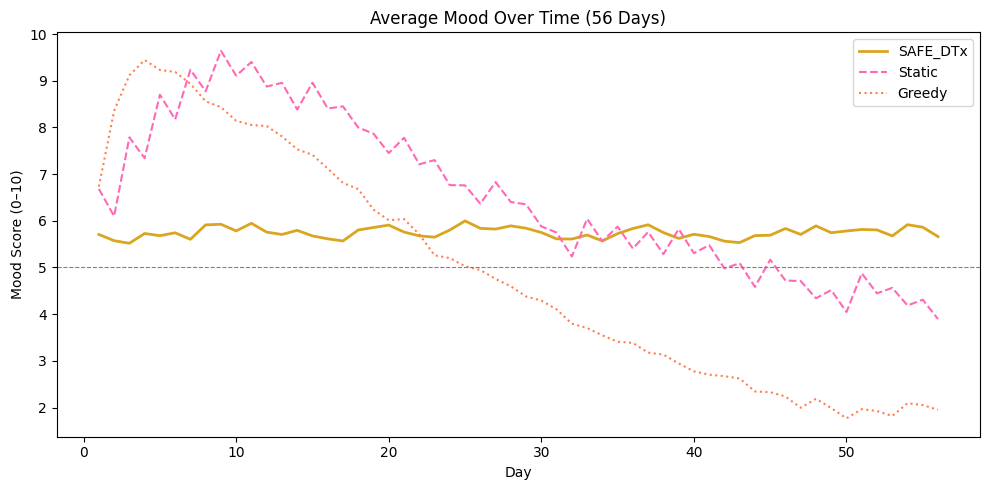

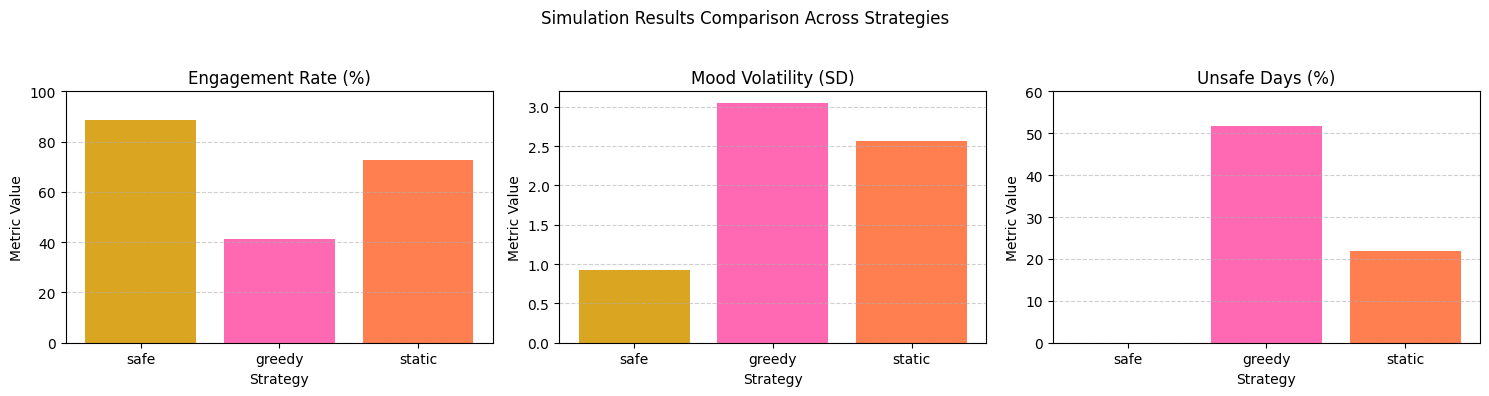

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting: average mood trajectories
time = np.arange(1, T + 1)
mood_safe = results['safe']['moods'][:, 1:].mean(axis=0)
mood_static = results['static']['moods'][:, 1:].mean(axis=0)
mood_greedy = results['greedy']['moods'][:, 1:].mean(axis=0)

plt.figure(figsize=(10, 5))
plt.plot(time, mood_safe, label='SAFE_DTx', color='goldenrod', linewidth=2)
plt.plot(time, mood_static, label='Static', color='hotpink', linestyle='--')
plt.plot(time, mood_greedy, label='Greedy', color='coral', linestyle=':')
plt.axhline(5, color='gray', linestyle='--', linewidth=0.8)
plt.title("Average Mood Over Time (56 Days)")
plt.xlabel("Day")
plt.ylabel("Mood Score (0–10)")
plt.legend()
plt.tight_layout()
plt.show()

# Bar plots for summary metrics
strategies = list(metrics.keys())
engagement = [metrics[s]['engagement_rate'] for s in strategies]
volatility = [metrics[s]['volatility'] for s in strategies]
unsafe = [metrics[s]['unsafe_days_pct'] for s in strategies]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(strategies, engagement, color=["goldenrod", "hotpink", "coral"])
axes[0].set_title("Engagement Rate (%)")
axes[0].set_ylim(0, 100)

axes[1].bar(strategies, volatility, color=["goldenrod", "hotpink", "coral"])
axes[1].set_title("Mood Volatility (SD)")

axes[2].bar(strategies, unsafe, color=["goldenrod", "hotpink", "coral"])
axes[2].set_title("Unsafe Days (%)")
axes[2].set_ylim(0, 60)

for ax in axes:
    ax.set_xlabel("Strategy")
    ax.set_ylabel("Metric Value")
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.suptitle("Simulation Results Comparison Across Strategies")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()